# Supervised Learning

# 05_supervised_learning_model

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 30/10/2025   | Martin | Created   | Notebook created for supervised learning model | 
| 01/10/2025   | Martin | New   | Added XGBoost and FFNN sections | 
| 05/10/2025   | Martin | Updated   | Tested on dummy target class. FF NN just tested | 
| 06/10/2025   | Martin | New   | Added section for feature importance and model inspection | 

# Content

* [Introduction](#introduction)
* [Load Data](#load-data)
* [Cost List](#cost-list)
* [Supervised Learning Models](#supervised-learning-models)
* [Feature Importance & Model Inspection](#feature-importance--model-inspection)
* [Sensitivity Analysis](#sensitivity-analysis)

# Introduction

In [1]:
%load_ext watermark

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# Load Data

In [ ]:
path = "../data/clean"
df = pd.read_pickle(f"{path}/patient_level.pkl")

In [188]:
df.head()

,patient_medicare_number,patient_first_name,patient_last_name,gender,birthdate,number_of_claims,drg_ls,combined_diagnosis_ls,combined_hcpcs_ls,billablePeriod_start_ls,billablePeriod_end_ls,location_of_bill_ls,total_value
1,1S00E00AA10,Brandon214,Roob72,female,1946-01-15,3,[],"[O039, O039, B085, B002, O039, J029]","[G0444, 99241, G0444, G9572]","[2013-04-23, 2016-01-15, 2020-06-02]","[2013-04-23, 2016-01-15, 2020-06-02]",[002],15458.12
3,1S00E00AA23,B.,Hagene,female,NaN,1,[],"[J329, E785, P292]","[G0444, G9572]",[2014-04-13],[2014-04-13],[],840.21
5,1S00E00AA25,Carlota980,Gamez720,female,1947-04-15,2,[],"[E669, D649, K635, O039, M810, J329, E669, D64...","[G0444, 99241]","[2012-07-18, 2021-11-23]","[2012-07-18, 2021-11-23]",[002],85.55
6,1S00E00AA32,Denny560,Watsica258,male,1945-06-09,3,[],"[P292, E669, I2510, B349, J329, I10, E669, I25...","[99241, 99241, 99241]","[2015-05-12, 2021-02-20, 2021-03-20]","[2015-05-12, 2021-02-20, 2021-03-20]","[002, 002, 002]",85.55
10,1S00E00AA54,Lashawnda5,Greenfelder433,female,1950-12-23,11,[],"[E119, R739, E781, E8881, D649, E11319, P292, ...","[G0444, 99241, 99241, 99241, 99241, G0444, 992...","[2012-10-27, 2013-01-26, 2014-06-21, 2014-07-2...","[2012-10-27, 2013-01-26, 2014-06-21, 2014-07-2...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",142.58


In [5]:
df_hcpcs = pd.read_pickle(f"{path}/hcpcs_tfidf.pkl")
df_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")

# Cost List

Get the cost of procedures from claims with single HCPCS based on the existing claims list

In [190]:
def get_price_list_from_hcpcs(df: pd.DataFrame, price_selection: str):
  """Retrieve the price of each HCPCS code from those claims that only have 1 code

  Args:
      df (pd.DataFrame): Patient Level dataset
      price_selection (str): Any aggregation function for group by ("max", "min", "mean"). 
          How to handle when multiple claims have the same singular code

  Returns:
      pd.DataFrame: Cost of each HCPCS
  """
  temp = df.copy()
  temp['hcpcs_len'] = temp['combined_hcpcs_ls'].str.len()

  # Get only those with single HCPC values
  cost = temp[temp['hcpcs_len'] == 1]

  # Only the select only the hcpcs codes and total bill
  cost['hcpcs_code'] = cost['combined_hcpcs_ls'].str[0]
  cost = cost[['hcpcs_code', 'total_value']]

  # Based on cost selection
  cost = cost.groupby('hcpcs_code').agg(price_selection)
  cost['total_value'] = np.round(cost['total_value'], 2)
  cost = cost.reset_index()
  cost = cost.rename({
    'total_value': 'cost'
  }, axis=1)

  return cost

In [191]:
cost = get_price_list_from_hcpcs(df, price_selection='mean')

C:\Users\User\AppData\Local\Temp\ipykernel_24796\3427604465.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost['hcpcs_code'] = cost['combined_hcpcs_ls'].str[0]


In [192]:
cost.head()

,hcpcs_code,cost
0,99221,5666.37
1,99241,2370.06
2,G0107,36515.28
3,G0151,526.33
4,G0152,1041.51


# Supervised Learning Models

Assumption: All the data is already numerically encoded

## Additional data processing

In [6]:
SEED = 43

Creating a temporary random cluster assignment to test supervised learning pipelines

In [7]:
NUM_CLUSTERS = 5

enc_cols = [i for i in df_enc.columns if i.endswith('enc')]
df_enc = df_enc[enc_cols]

rng = np.random.default_rng()
temporary_class = rng.integers(low=0, high=NUM_CLUSTERS, size=df_enc.shape[0])
df_enc['temp_class'] = temporary_class

/var/folders/df/6w983x9x0cg5pppshqj46f500000gn/T/ipykernel_9678/2420392122.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enc['temp_class'] = temporary_class


In [8]:
rng = np.random.default_rng()
temporary_class = rng.integers(low=0, high=NUM_CLUSTERS, size=df_hcpcs.shape[0])
df_hcpcs['temp_class'] = temporary_class
df_hcpcs = df_hcpcs.reset_index(drop=True)

In [9]:
# Additional processing for HCPCS TFIDF df
df_hcpcs = df_hcpcs.drop('birthdate', axis=1)

avg_num_claims = int(np.mean(df_hcpcs[~df_hcpcs['number_of_claims'].isna()]['number_of_claims']))
df_hcpcs['number_of_claims'] = df_hcpcs['number_of_claims'].fillna(avg_num_claims)


fill = df_hcpcs[df_hcpcs['gender'].isna()].shape[0]
gender_fill = [['male', 'female'][rng.integers(low=0, high=2)] for _ in range(fill)]
df_hcpcs.loc[df_hcpcs['gender'].isna(), 'gender'] = gender_fill

le_gender = LabelEncoder()
df_hcpcs['gender'] = le_gender.fit_transform(df_hcpcs['gender'])

In [197]:
# Perform additional steps here

## Split Data

Create train, validation and test splits in __stratified__ manner

- Train: 70%
- Validation: 15%
- Test: 15%

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedShuffleSplit

In [13]:
df = df_hcpcs.copy()
df = df.rename({
  'temp_class': 'target'
}, axis=1)
df.head()

,gender,number_of_claims,T1502,G0424,G0107,G9829,T1021,G9858,G0464,G9708,...,G0152,G0129,S0605,G0402,G0458,G0300,G0155,G0158,G8111,target
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [14]:
# Change values here
train_size = 0.7
test_size = 0.5

In [15]:
y = df['target']
train, temp = train_test_split(df, train_size=train_size, stratify=y, random_state=SEED)
val, test = train_test_split(temp, train_size=test_size, stratify=temp['target'], random_state=SEED)

In [16]:
strat = pd.concat([train, val], axis=0).reset_index(drop=True)
y_strat = strat['target']
X_strat = strat.drop('target', axis=1)

In [17]:
y_train = train['target']
X_train = train.drop('target', axis=1)

y_val = val['target']
X_val = val.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)

## Metrics

Common classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score (weighted or micro)
- ROC AUC Score (OVR + weighted)

Plots:

- Confusion Matrix
- ROC AUC

In [19]:
def metrics_score(y_true, y_pred):
  acc = round(accuracy_score(y_true, y_pred), 4)
  prec = round(precision_score(y_true, y_pred, average='weighted'), 4)
  recall = round(recall_score(y_true, y_pred, average='weighted'), 4)
  f1 = round(f1_score(y_true, y_pred, average="weighted"), 4)
  # roc_auc = round(roc_auc_score(y_true, y_pred, average="weighted", multi_class="ovr"), 4)

  return acc, prec, recall, f1

In [20]:
def plot_confusion_matrix(y_true, y_pred, clf):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_
  )

  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [206]:
def plot_ROC_AUC():
  # TODO: Determine which method of comparison should be used
  return

## Baseline: Dummy Classifier

Uses sklearns dummy classifier to test various baseline strategies

In [230]:
# Change here
strategy = "most_frequent"

In [231]:
dummy_clf = DummyClassifier(strategy=strategy)
dummy_clf.fit(X_train, y_train)

preds = dummy_clf.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 21.01%
Precision: 4.41%
Recall: 21.01%
F1: 7.3%


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


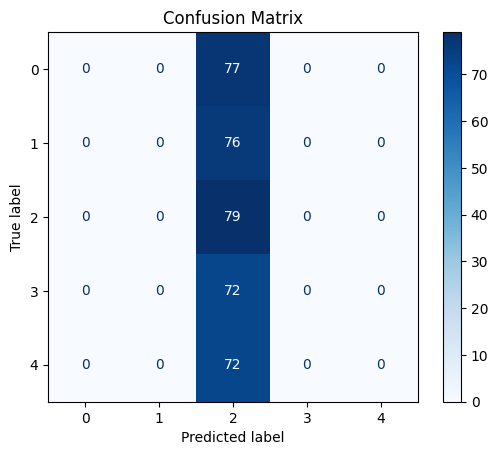

In [232]:
plot_confusion_matrix(y_val, preds, dummy_clf)

## Model 1: Logistic Regression

Simple logistic regression model for an improved baseline

In [210]:
# For model tuning

In [21]:
lr_model = OneVsRestClassifier(LogisticRegression(random_state=SEED))
# lr_model = OneVsOneClassifier(LogisticRegression(random_state=SEED))

lr_model.fit(X_train, y_train)
preds = lr_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 19.15%
Precision: 20.26%
Recall: 19.15%
F1: 18.709999999999997%


/Users/martz/venv/py311_venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/martz/venv/py311_venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/martz/venv/py311_venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/martz/venv/py311_venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/martz/venv/py311_venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_

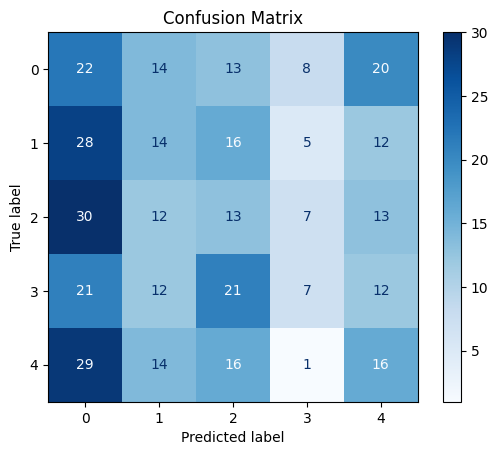

In [22]:
plot_confusion_matrix(y_val, preds, lr_model)

In [235]:
# For K-Fold shuffled stratified cross validation
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
lr_model = OneVsRestClassifier(LogisticRegression(random_state=SEED))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  lr_model.fit(X_strat_train, y_strat_train)

  preds = lr_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")


========== Split 0 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 20.14%
Precision: 20.51%
Recall: 20.14%
F1: 19.07%

========== Split 1 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 22.95%
Precision: 23.89%
Recall: 22.95%
F1: 21.57%

========== Split 2 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 21.310000000000002%
Precision: 24.29%
Recall: 21.310000000000002%
F1: 20.78%

========== Split 3 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 18.970000000000002%
Precision: 19.38%
Recall: 18.970000000000002%
F1: 18.82%

========== Split 4 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 23.419999999999998%
Precision: 23.59%
Recall: 23.419999999999998%
F1: 22.45%

========== Split 5 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 23.189999999999998%
Precision: 24.11%
Recall: 23.189999999999998%
F1: 22.720000000000002%

========== Split 6 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 19.2%
Precision: 18.23%
Recall: 19.2%
F1: 18.07%

========== Split 7 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 19.439999999999998%
Precision: 19.16%
Recall: 19.439999999999998%
F1: 18.35%

========== Split 8 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 21.310000000000002%
Precision: 21.790000000000003%
Recall: 21.310000000000002%
F1: 20.46%

========== Split 9 ==========


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

Accuracy: 21.310000000000002%
Precision: 21.310000000000002%
Recall: 21.310000000000002%
F1: 20.91%


d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

## Model 2: Decision Tree / Random Forest

Similar reason for decision tree except more interpretable. Random forest for boosting improvements

In [34]:
# For model tuning
config = {
  "max_depth": 10,
  "min_samples_split": 2,
  "min_samples_leaf": 1
}

In [35]:
dt_model = DecisionTreeClassifier(**config, random_state=SEED)

dt_model.fit(X_train, y_train)
preds = dt_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 21.279999999999998%
Precision: 36.42%
Recall: 21.279999999999998%
F1: 11.52%


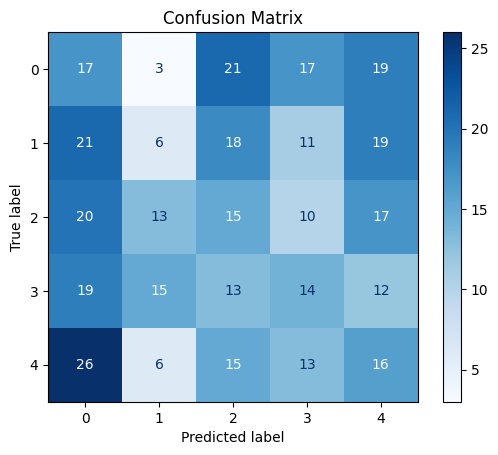

In [25]:
plot_confusion_matrix(y_val, preds, dt_model)

In [239]:
# For K-Fold shuffled stratified cross validation
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
dt_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  dt_model.fit(X_strat_train, y_strat_train)

  preds = dt_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")


========== Split 0 ==========
Accuracy: 17.1%
Precision: 16.73%
Recall: 17.1%
F1: 16.619999999999997%

========== Split 1 ==========
Accuracy: 20.14%
Precision: 21.01%
Recall: 20.14%
F1: 19.98%

========== Split 2 ==========
Accuracy: 20.84%
Precision: 21.86%
Recall: 20.84%
F1: 20.79%

========== Split 3 ==========
Accuracy: 18.029999999999998%
Precision: 19.05%
Recall: 18.029999999999998%
F1: 17.810000000000002%

========== Split 4 ==========
Accuracy: 18.740000000000002%
Precision: 19.07%
Recall: 18.740000000000002%
F1: 18.7%

========== Split 5 ==========
Accuracy: 18.27%
Precision: 18.48%
Recall: 18.27%
F1: 17.91%

========== Split 6 ==========
Accuracy: 18.27%
Precision: 18.45%
Recall: 18.27%
F1: 17.83%

========== Split 7 ==========
Accuracy: 18.27%
Precision: 18.26%
Recall: 18.27%
F1: 17.27%

========== Split 8 ==========
Accuracy: 18.5%
Precision: 18.66%
Recall: 18.5%
F1: 18.23%

========== Split 9 ==========
Accuracy: 17.8%
Precision: 17.34%
Recall: 17.8%
F1: 17.28%


Random Forest Classifier

In [240]:
# For model tuning
config = {
  "n_estimators": 100,
  "max_depth": None,
  "min_samples_split": 2,
  "min_samples_leaf": 1
}

In [241]:
rf_model = RandomForestClassifier(**config, random_state=SEED)

rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 19.68%
Precision: 19.439999999999998%
Recall: 19.68%
F1: 19.3%


In [242]:
# For K-Fold shuffled stratified cross validation
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
rf_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  rf_model.fit(X_strat_train, y_strat_train)

  preds = rf_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")


========== Split 0 ==========
Accuracy: 17.1%
Precision: 16.73%
Recall: 17.1%
F1: 16.619999999999997%

========== Split 1 ==========
Accuracy: 20.14%
Precision: 21.01%
Recall: 20.14%
F1: 19.98%

========== Split 2 ==========
Accuracy: 20.84%
Precision: 21.86%
Recall: 20.84%
F1: 20.79%

========== Split 3 ==========
Accuracy: 18.029999999999998%
Precision: 19.05%
Recall: 18.029999999999998%
F1: 17.810000000000002%

========== Split 4 ==========
Accuracy: 18.740000000000002%
Precision: 19.07%
Recall: 18.740000000000002%
F1: 18.7%

========== Split 5 ==========
Accuracy: 18.27%
Precision: 18.48%
Recall: 18.27%
F1: 17.91%

========== Split 6 ==========
Accuracy: 18.27%
Precision: 18.45%
Recall: 18.27%
F1: 17.83%

========== Split 7 ==========
Accuracy: 18.27%
Precision: 18.26%
Recall: 18.27%
F1: 17.27%

========== Split 8 ==========
Accuracy: 18.5%
Precision: 18.66%
Recall: 18.5%
F1: 18.23%

========== Split 9 ==========
Accuracy: 17.8%
Precision: 17.34%
Recall: 17.8%
F1: 17.28%


## Model 3: XGBoost

Larger improvement over standard decision tree and random forest

In [243]:
config = {
  "num_class": 10, # Change this based on number of cluster outputs
  "n_estimators": 100,
  "max_depth": 2,
  "learning_rate": 1
}

In [244]:
xgb_model = XGBClassifier(**config, objective="multi:softmax", random_state=SEED)

xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 20.21%
Precision: 20.419999999999998%
Recall: 20.21%
F1: 19.85%


Feature importance metrics in XGBoost Trees:

- `gain` - A measure of the improvement in model performance or reduction in loss achieved by using a specific feature to split a node in a decision tree
- `weight` - The number of times a feature is used to split the data across all trees

In [223]:
# Feature importance with built in XGBoost module
feature_importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
print("Feature Importance (Gain):")
for feature, importance in feature_importance_gain.items():
  print(f"{feature}: {importance}")

feature_importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
print("Feature Importance (Weight):")
for feature, importance in feature_importance_weight.items():
  print(f"{feature}: {importance}")

Feature Importance (Gain):
gender: 0.6981925368309021
number_of_claims: 0.5436623692512512
T1502: 0.6097864508628845
G0424: 0.317256361246109
G0107: 0.33977657556533813
G9829: 0.43119707703590393
T1021: 0.30784204602241516
G9858: 0.6996098160743713
G0464: 0.5839318633079529
99241: 0.6418401002883911
H2000: 0.6413297653198242
S9122: 0.3195582330226898
G0157: 0.7950478196144104
S8075: 0.47460269927978516
G0156: 0.6526128053665161
G0299: 0.6622011065483093
G9573: 0.46239686012268066
Q5001: 0.5274736285209656
G9572: 0.5359485745429993
G0444: 0.7898593544960022
S9129: 0.571814239025116
G9857: 0.6607046723365784
S9131: 0.5961360931396484
G0153: 0.4493638873100281
S9473: 0.3436243236064911
99221: 0.7572539448738098
S9126: 0.8565569519996643
G0151: 0.4684673249721527
G0154: 0.5823715329170227
G0152: 0.49067485332489014
G0129: 0.7471277713775635
G0402: 0.5401214957237244
G0300: 0.5632427334785461
G0155: 0.7315208911895752
G0158: 0.8401288390159607
G8111: 0.5277122259140015
Feature Importance (W

## Model 4: FF Neural Network

NOTE: Workflow works, but output needs to be one hot encoded

In [2]:
import tensorflow as tf
import keras.models
from tensorflow import keras
from keras.layers import Input, Dense, ReLU, BatchNormalization, Dropout

In [31]:
# Parameters and Tuning
input_shape = (42, ) # Number of columns
output_shape = 5 # Number of clusters (targets)
optimizer = "sgd"
loss = "categorical_crossentropy" # If target is one-hot encoded sparse_categorical_crossentropy
num_epochs = 10 

In [32]:
inputs = Input(input_shape)

# 2 Layer MLP
dense_layer_1 = Dense(64)(inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
relu_1 = ReLU()(batch_norm_1)
dropout_1 = Dropout(rate=0.1)(relu_1)

dense_layer_2 = Dense(64)(dropout_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)
relu_2 = ReLU()(batch_norm_2)
dropout_2 = Dropout(rate=0.1)(relu_2)

outputs = Dense(output_shape, activation='softmax')(dropout_2)

model = keras.Model(inputs=inputs, outputs=outputs)

In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,749 (30.27 KB)

 Trainable params: 7,493 (29.27 KB)

 Non-trainable params: 256 (1.00 KB)

In [34]:
model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=[
    keras.metrics.CategoricalAccuracy(),
    keras.metrics.Precision(),
    keras.metrics.Recall(),
  ]
)

In [36]:
model.fit(
  X_train,
  y_train.toarray(),
  validation_data=[X_val, y_val.toarray()],
  epochs=num_epochs
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.1861 - loss: 1.9244 - precision_1: 0.1444 - recall_1: 0.0201 - val_categorical_accuracy: 0.2131 - val_loss: 1.6377 - val_precision_1: 0.3333 - val_recall_1: 0.0020
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1905 - loss: 1.7411 - precision_1: 0.1615 - recall_1: 0.0096 - val_categorical_accuracy: 0.1853 - val_loss: 1.6311 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2189 - loss: 1.6840 - precision_1: 0.2042 - recall_1: 0.0097 - val_categorical_accuracy: 0.1793 - val_loss: 1.6279 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1951 - loss: 1.6933 - precision_1: 0.3283 - recall_1: 0.0133 - val_categorical_accuracy: 0.1912 - val_loss: 1.6228 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/10
63/63

# Feature Importance & Model Inspection

Explore the contributing factors of the model and evaluate the model's effectiveness in predictions

## Feature Importance

1. Decision tree visualisation + importance
2. Partial dependence plot
3. Permutation importance

### 1. Decision trees

- Plotted decision tree allows people to trace the path of the decision based on the feature values, making the results understandable
- Feature importance plot shows which feature caused the greatest reduction in variance of gini coefficient compared to their parent node, making that feature more important

In [27]:
from sklearn.tree import plot_tree

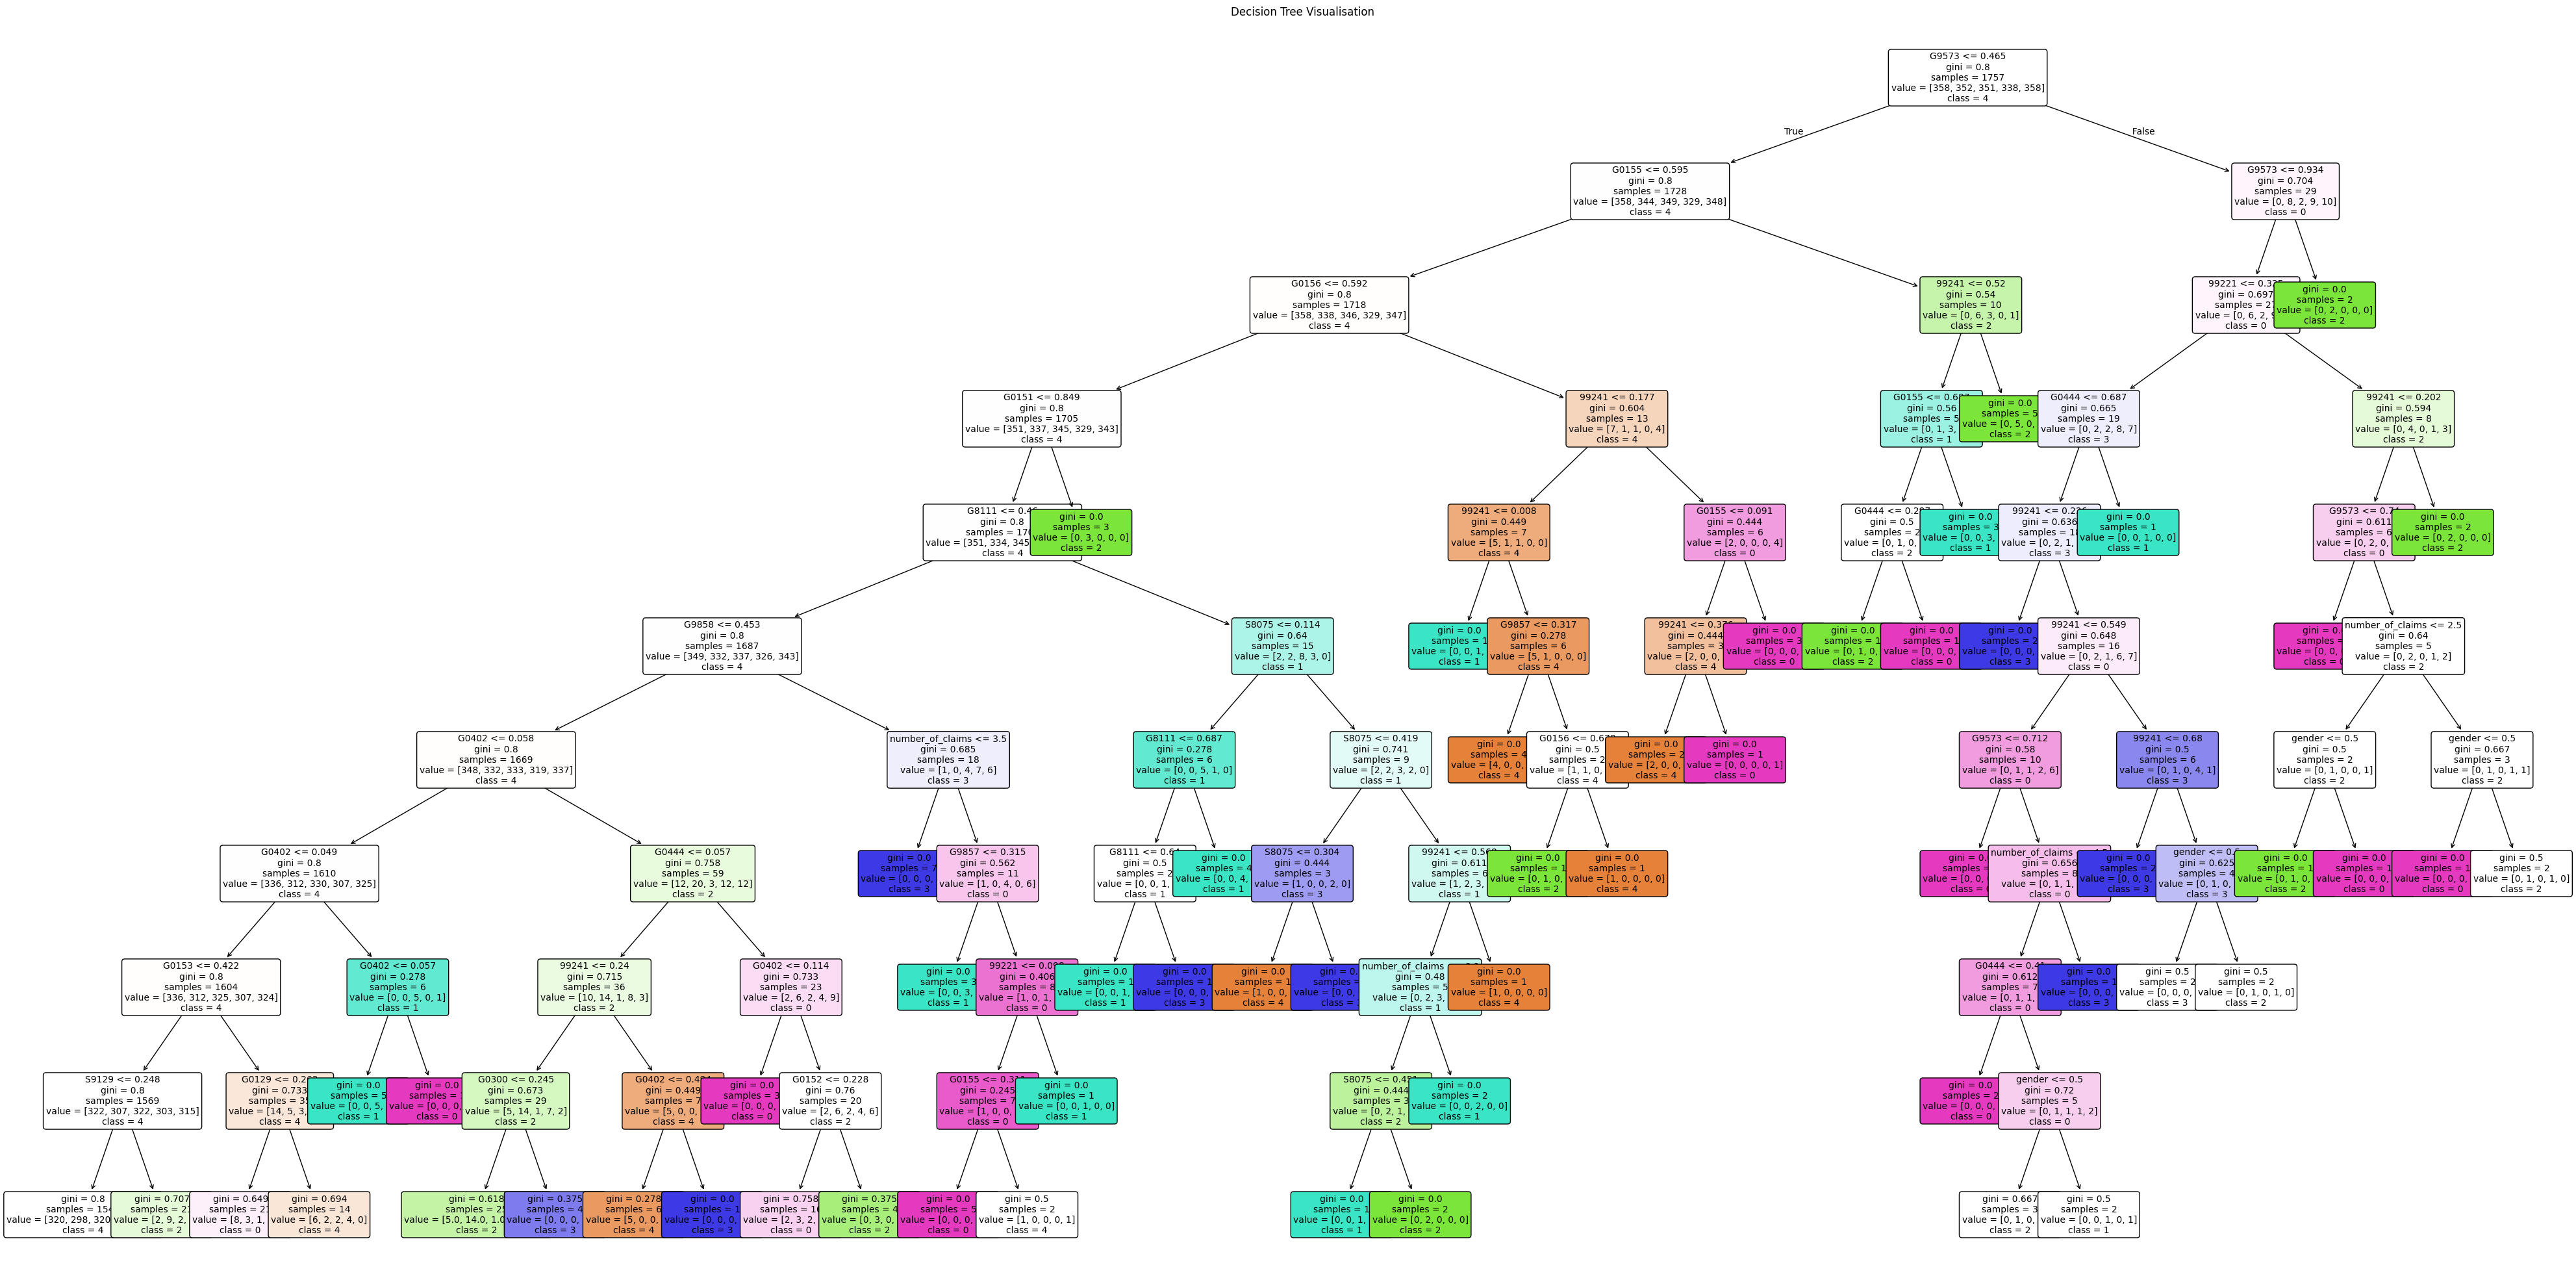

In [41]:
fig, ax = plt.subplots(figsize=(50, 25))
plot_tree(
  dt_model,
  feature_names=X_train.columns,
  class_names=y_train.unique().astype(str),
  filled=True,
  rounded=True,
  fontsize=10
)
plt.title("Decision Tree Visualisation")
plt.show()

Text(0.5, 1.0, 'Feature Importance According to Decision Tree Model')

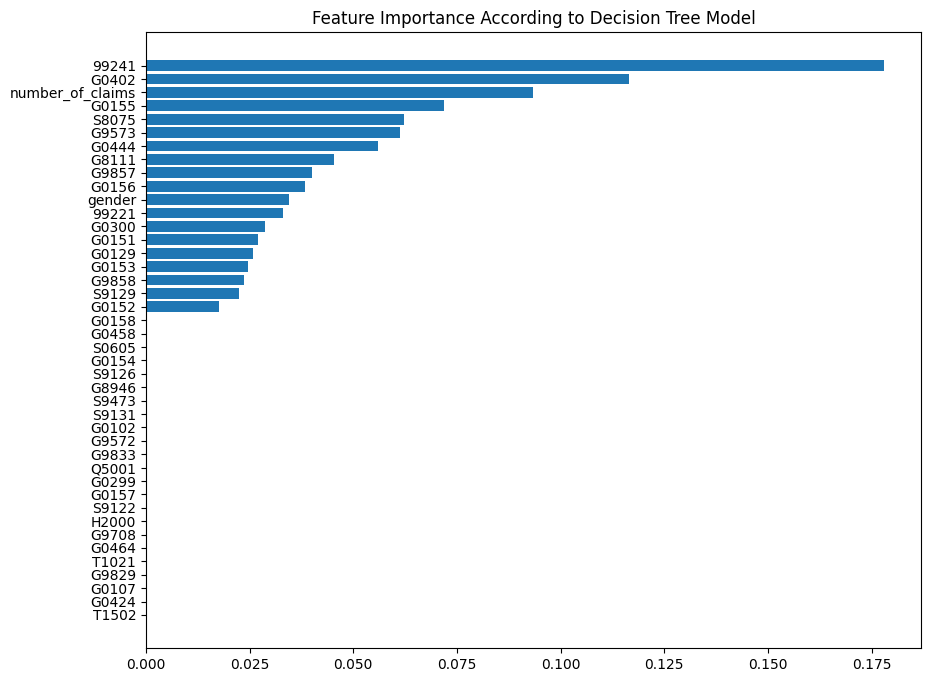

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
dt_importance = {k: v for k, v in zip(X_train.columns, dt_model.feature_importances_)}
dt_importance = dict(sorted(dt_importance.items(), key=lambda kv: kv[1]))
plt.barh(dt_importance.keys(), dt_importance.values())
plt.title("Feature Importance According to Decision Tree Model")

### 2. Partial dependence plot

- PDP plots select a feature (or a set of features) and fix the average of all other features
- It then iterates through the range of the selected feature and produces a predicted value for each entry, with only the selected feature varying
- If there is a large fluctuation, then the feature is important

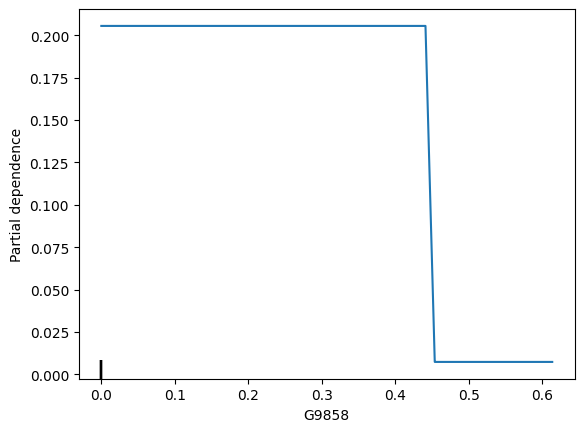

In [85]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
  estimator=dt_model,
  X=X_train,
  features=['G9858'],
  target=0
  # categorical_features=,
)


/Users/martz/venv/py311_venv/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:995: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


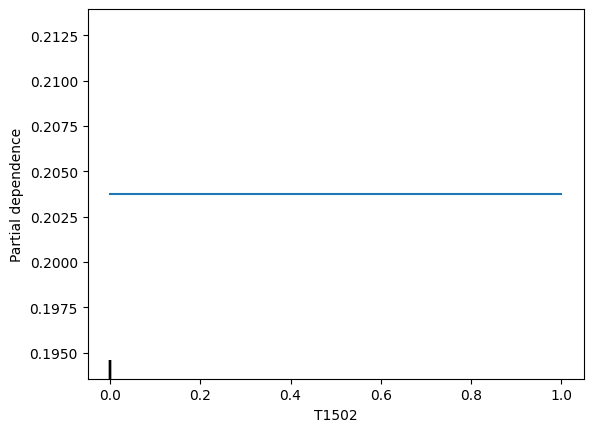

In [74]:
PartialDependenceDisplay.from_estimator(
  estimator=dt_model,
  X=X_train,
  features=['T1502'],
  target=0
  # categorical_features=,
)

### 3. Permutation importance

- Acts as a form of ablation study
- Similar to PDP plot but feature interactions are preserved (assuming the model automatically accounts for them)
- Select a feature and it randomly shuffles that feature values then makes predictions
- If the deviation from the true value increases significantly from the original model, then that feature is considered important

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

multiclass_scorer = make_scorer(precision_score, average='weighted')

result = permutation_importance(
  estimator=dt_model,
  X=X_test,
  y=y_test,
  scoring=multiclass_scorer,
  n_repeats=10,
  random_state=SEED
)

Text(0, 0.5, 'Feature')

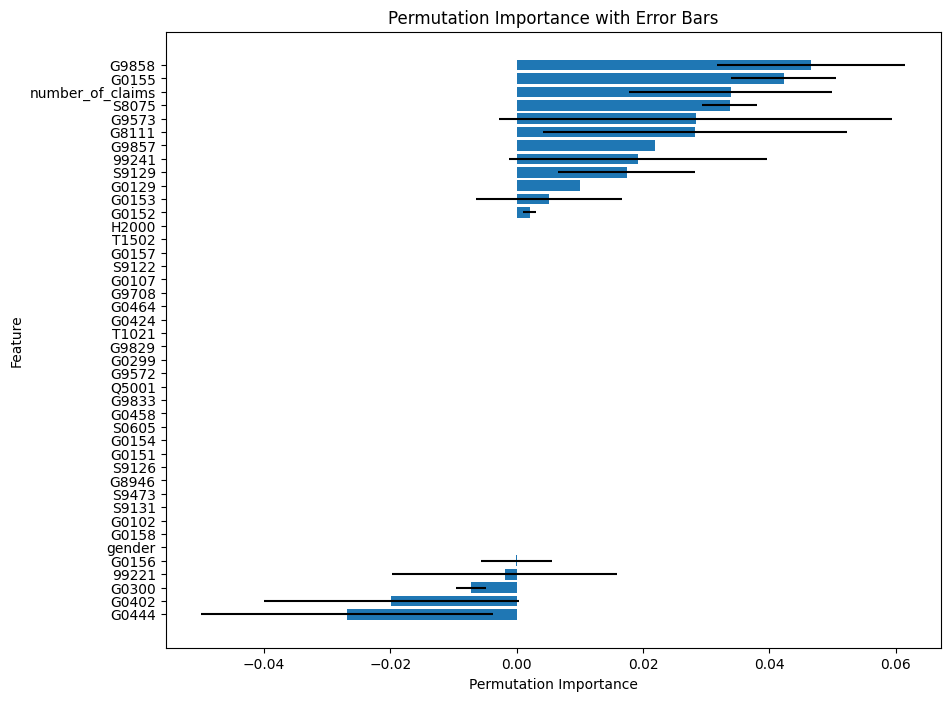

In [87]:
importance_means = result['importances_mean']
importance_std = result['importances_std']

sorted_idx = importance_means.argsort()
df_perm_impt = pd.DataFrame({
  "impt_mean": importance_means[sorted_idx],
  "impt_std": importance_std[sorted_idx],
  "feature": np.array(X_test.columns)[sorted_idx]
})

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(
  df_perm_impt['feature'],
  df_perm_impt['impt_mean'],
  xerr=df_perm_impt['impt_std'],
  align='center'
)
plt.title("Permutation Importance with Error Bars")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")

In [79]:
len(X_test.columns)

42

# Sensitivity Analysis

In [ ]:
%watermark